In [1]:
# Load Libraries
import pandas as pd
import pickle
from pandas import DataFrame, Series
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn import linear_model, naive_bayes
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,r2_score
import pybaseball as pyb
from pybaseball import statcast
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix ,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

In [2]:
# Import Data
df = pd.read_csv("/Users/genoc/Desktop/HyannisHarborHawks/Trackman/Cape_Trackman_Combined_July7.csv",low_memory=False)

# Clean Trackman Data
dft = df[['Pitcher', 'PitcherTeam', 'Batter', 'BatterTeam', 'PitcherThrows', 'RelSpeed','SpinRate','RelHeight','RelSide','Extension','InducedVertBreak', 'HorzBreak', 'PitchCall', 'PlayResult', 'TaggedHitType', 'KorBB']]

#Rename the columns to be more descriptive
dft.rename(columns={'BatterTeam':'Batter Team', 'PitcherTeam':'Pitcher Team', 'PitcherThrows':'P Side', 'RelSpeed':'Velocity', 'SpinRate':'Spin Rate', 'RelHeight':'Release Height', 'RelSide':'Release Side', 'Extension':'Extension', 'InducedVertBreak':'Induced Vertical Break', 'HorzBreak':'Horizontal Break', 'PitchCall':'Pitch Call', 'PlayResult':'Play Result', 'TaggedHitType':'Hit Type'}, inplace=True)

#Add the Pitch Type and Pitch Result to the new dataframe
dft.insert(1, 'Pitch Type', df['TaggedPitchType'])
dft.insert(2, 'Pitch Result', df['PitchCall'])

#Create a new column for the difference between the Induced Vertical Break and the Horizontal Break (Absolute Value)
dft['Differential Break'] = (dft['Induced Vertical Break'] - dft['Horizontal Break']).abs()

#Add two new columns for Pitch Location
dft.insert(10, 'Pitch Height', df['PlateLocHeight'])
dft.insert(11, 'Pitch Side', df['PlateLocSide'])

#Edit Horizontal Break to be absolute value of horizontal break
dft['Horizontal Break'] = abs(dft['Horizontal Break'])

dft['Release Side'] = abs(dft['Release Side'])

# Edit the pitcher names so the first name is first and the last name is last
dft['Pitcher'] = dft['Pitcher'].str.split(' ', expand=True)[1] + ' ' + dft['Pitcher'].str.split(' ', expand=True)[0]

# Edit the batter names so the first name is first and the last name is last
dft['Batter'] = dft['Batter'].str.split(' ', expand=True)[1] + ' ' + dft['Batter'].str.split(' ', expand=True)[0]

# Remove the comma from the last name
dft = dft.replace(',', '', regex=True)

# Add Swings and Misses to dft
dft['Whiff'] = dft['Pitch Call'].apply(lambda x: 1 if x == "StrikeSwinging" else 0)
dft['Swing'] = dft['Pitch Call'].apply(lambda x: 1 if x == "StrikeSwinging" or x == "InPlay" else 0)

# Calculates total swings and total misses across all of dft
total_swings = dft['Swing'].sum()
total_misses = dft['Whiff'].sum()

# Calculates Whiff Rate for all of dft
league_average_whiff_rate = total_misses / total_swings

# Create a new dataframe with only pitches that are Fastballs and Changeups
dfbr = dft[(dft['Pitch Type'] == 'Changeup') | (dft['Pitch Type'] == 'Fastball')]

C:\Users\genoc\Anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-2-c0d55003a503>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft['Differential Break'] = (dft['Induced Vertical Break'] - dft['Horizontal Break']).abs()
<ipython-input-2-c0d55003a503>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [5]:
# Group the data by 'Pitcher' and calculate the mean fastball velocity for each pitcher
average_fb_velocity = dfbr[dfbr['Pitch Type'] == 'Fastball'].groupby('Pitcher')['Velocity'].mean()
average_fb_velocity = average_fb_velocity.round(2)

In [6]:
# Handle NA values
dfbr.fillna(dfbr.mean(), inplace=True)

#dfbr[['Velocity', 'Spin Rate', 'Release Height', 'Release Side', 'Extension', 'Horizontal Break', 'Differential Break', 'Induced Vertical Break']].corr()

df_ch = dfbr[(dfbr['Pitch Type'] == 'Changeup')]

C:\Users\genoc\Anaconda3\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [7]:
df_ch[['Velocity', 'Spin Rate', 'Release Height', 'Release Side', 'Extension', 'Horizontal Break', 'Differential Break', 'Induced Vertical Break']].corr()

,Velocity,Spin Rate,Release Height,Release Side,Extension,Horizontal Break,Differential Break,Induced Vertical Break
Velocity,1.000000,0.145071,0.006803,0.027134,0.111360,-0.026285,-0.152415,0.248143
Spin Rate,0.145071,1.000000,-0.077348,0.077393,-0.069296,0.126856,0.122764,-0.037805
Release Height,0.006803,-0.077348,1.000000,-0.302285,-0.035917,-0.222455,-0.091994,0.305287
Release Side,0.027134,0.077393,-0.302285,1.000000,0.152334,0.110912,0.006203,-0.141738
Extension,0.111360,-0.069296,-0.035917,0.152334,1.000000,0.040361,-0.044906,0.034042
Horizontal Break,-0.026285,0.126856,-0.222455,0.110912,0.040361,1.000000,0.340667,-0.140086
Differential Break,-0.152415,0.122764,-0.091994,0.006203,-0.044906,0.340667,1.000000,0.007165
Induced Vertical Break,0.248143,-0.037805,0.305287,-0.141738,0.034042,-0.140086,0.007165,1.000000


In [8]:
df_ch['Horizontal Break Pow'] = pow(df_ch['Horizontal Break'], 3) + pow(df_ch['Horizontal Break'], 2)
df_ch['Release Height^3'] = pow(df_ch['Release Height'], 3)
df_ch['Release Side^2'] = pow(df_ch['Release Side'], 2)
df_ch['IVB Pow'] = pow(df_ch['Induced Vertical Break'], 3) + pow(df_ch['Induced Vertical Break'], 2)

# Filter to only include swings
dfbr_swing = df_ch[(df_ch['Swing'] == 1)]

<ipython-input-8-a8f8f1a1cd9e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ch['Horizontal Break Pow'] = pow(df_ch['Horizontal Break'], 3) + pow(df_ch['Horizontal Break'], 2)
<ipython-input-8-a8f8f1a1cd9e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ch['Release Height^3'] = pow(df_ch['Release Height'], 3)
<ipython-input-8-a8f8f1a1cd9e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [9]:
# Linear regression Model

X = dfbr_swing[['Release Height^3', 'Extension', 'Velocity', 'Spin Rate', 'Release Side^2', 'Horizontal Break Pow', 'IVB Pow', 'Differential Break']]
# Original: X = dfbr[['Velocity', 'Spin Rate', 'Induced Vertical Break', 'Horizontal Break', 'Differential Break', 'Release Height', 'Release Side', 'Extension', 'Hgt x IVB', 'Velo^3 + Velo^2', 'IndVert^2', 'DiffBreak^2']]
y = dfbr_swing['Whiff']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a linear regression object
linear_model = LinearRegression()

# Train the linear regression model using the training data
linear_model.fit(X_train_scaled, y_train)

# Predict Stuff+ scores for the test set using the linear regression model
y_linear_pred = linear_model.predict(X_test_scaled)

# Evaluate the linear regression model's performance
linear_mse = mean_squared_error(y_test, y_linear_pred)
linear_r2 = r2_score(y_test, y_linear_pred)

print("Linear Regression Mean Squared Error:", linear_mse)
print("Linear Regression R-squared score:", linear_r2)

Linear Regression Mean Squared Error: 0.2546756835518567
Linear Regression R-squared score: -0.026000458472948074


In [10]:
# Get the feature coefficients from the model
feature_importances = linear_model.coef_

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'importance': feature_importances}, index=X_train.columns)

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Print the feature importances
print(feature_importances_df)


                      importance
Horizontal Break Pow    0.034739
Velocity                0.030632
Differential Break      0.019971
Extension               0.015711
Release Height^3        0.007065
Release Side^2         -0.000124
IVB Pow                -0.021417
Spin Rate              -0.022482


In [11]:
# Random Forest Model

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a Random Forest regressor object
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the Random Forest model using the training data
random_forest_model.fit(X_train, y_train)

# Predict Stuff+ scores for the test set using the Random Forest model
y_rf_pred = random_forest_model.predict(X_test)

# Evaluate the Random Forest model's performance
rf_mse = mean_squared_error(y_test, y_rf_pred)
rf_r2 = r2_score(y_test, y_rf_pred)

print("Random Forest Mean Squared Error:", rf_mse)
print("Random Forest R-squared score:", rf_r2)

Random Forest Mean Squared Error: 0.2565879178151692
Random Forest R-squared score: -0.03370419054309992


In [12]:
# Get feature importances from the model
feature_importances = random_forest_model.feature_importances_

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'importance': feature_importances}, index=X_train.columns)

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Print the feature importances
print(feature_importances_df)

                      importance
Release Height^3        0.139069
Release Side^2          0.137852
IVB Pow                 0.126674
Extension               0.125140
Horizontal Break Pow    0.123514
Spin Rate               0.122450
Velocity                0.119574
Differential Break      0.105726


In [13]:
# XG Boost Model

# Standardize the features for better SVR training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the XGBoost regressor object
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the XGBoost model using the training data
xgb_model.fit(X_train_scaled, y_train)

# Predict Stuff+ scores for the test set using the XGBoost model
y_xgb_pred = xgb_model.predict(X_test_scaled)

# Evaluate the XGBoost model's performance
xgb_mse = mean_squared_error(y_test, y_xgb_pred)
xgb_r2 = r2_score(y_test, y_xgb_pred)

print("XGBoost Mean Squared Error:", xgb_mse)
print("XGBoost R-squared score:", xgb_r2)

XGBoost Mean Squared Error: 0.2641329317744945
XGBoost R-squared score: -0.06410044853479113


In [14]:
# Get feature importances from the model
feature_importances = xgb_model.feature_importances_

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'importance': feature_importances}, index=X_train.columns)

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Print the feature importances
print(feature_importances_df)

                      importance
Horizontal Break Pow    0.146143
Differential Break      0.144045
IVB Pow                 0.137951
Spin Rate               0.129576
Release Side^2          0.125845
Extension               0.108308
Velocity                0.104250
Release Height^3        0.103883


In [15]:
# SVR Model 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features for better SVR training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the Support Vector Regression model
svr_model = SVR(kernel='linear')

# Train the model using the training data
svr_model.fit(X_train_scaled, y_train)

# Predict Stuff+ scores for the test set using the SVR model
y_pred = svr_model.predict(X_test_scaled)

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate the R-squared score (coefficient of determination)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared score:", r2)

Mean Squared Error: 0.32191642771639906
R-squared score: -0.2968902166890488


In [16]:
# Neural Networks Model

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features for better neural network training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the Neural Network model
nn_model = Sequential()
nn_model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(1))  # Single output neuron for the Stuff+ score prediction

# Compile the model
nn_model.compile(optimizer='adam', loss='mse')

# Train the model using the training data
nn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0)

# Predict Stuff+ scores for the test set using the Neural Network model
y_pred = nn_model.predict(X_test_scaled).flatten()

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate the R-squared score (coefficient of determination)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared score:", r2)

8/8 [==============================] - 0s 3ms/step
Mean Squared Error: 0.3046366421788829
R-squared score: -0.22727592278966346


In [17]:
# Ensemble model

# Make predictions using all the models
linear_pred = linear_model.predict(X_test_scaled)
rf_pred = random_forest_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)
svr_pred = svr_model.predict(X_test_scaled)
keras_nn_pred = nn_model.predict(X_test_scaled).flatten()

# Combine predictions using averaging
ensemble_predictions = (linear_pred + rf_pred + xgb_pred + svr_pred + keras_nn_pred) / 5.0

8/8 [==============================] - 0s 4ms/step


In [18]:
# Get feature importances from the RandomForestRegressor and XGBRegressor models
rf_feature_importances = random_forest_model.feature_importances_
xgb_feature_importances = xgb_model.feature_importances_

# Calculate average feature importances across the two models
average_feature_importances = (rf_feature_importances + xgb_feature_importances) / 2.0

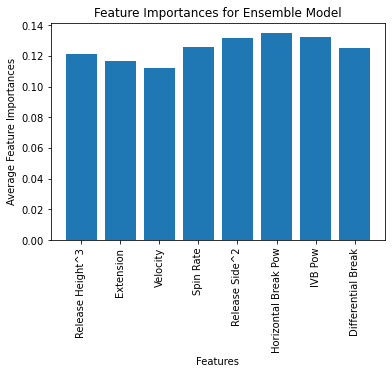

In [19]:
features_list = ['Release Height^3', 'Extension', 'Velocity', 'Spin Rate', 'Release Side^2', 'Horizontal Break Pow', 'IVB Pow', 'Differential Break']

plt.bar(features_list, average_feature_importances)
plt.xlabel('Features')
plt.ylabel('Average Feature Importances')
plt.title('Feature Importances for Ensemble Model')
plt.xticks(rotation=90)
plt.show()

In [22]:
X = df_ch[['Release Height^3', 'Extension', 'Velocity', 'Spin Rate', 'Release Side^2', 'Horizontal Break Pow', 'IVB Pow', 'Differential Break']]
# Original: X = dfbr[['Velocity', 'Spin Rate', 'Induced Vertical Break', 'Horizontal Break', 'Differential Break', 'Release Height', 'Release Side', 'Extension', 'Hgt x IVB', 'Velo^3 + Velo^2', 'IndVert^2', 'DiffBreak^2']]
y = df_ch['Whiff']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
# Make predictions on the training set using all the models
linear_pred_train = linear_model.predict(X_train_scaled)
rf_pred_train = random_forest_model.predict(X_train_scaled)
xgb_pred_train = xgb_model.predict(X_train_scaled)
svr_pred_train = svr_model.predict(X_train_scaled)
keras_nn_pred_train = nn_model.predict(X_train_scaled).flatten()

95/95 [==============================] - 0s 1ms/step


In [24]:
# Make predictions on the test set using all the models
linear_pred_test = linear_model.predict(X_test_scaled)
rf_pred_test = random_forest_model.predict(X_test_scaled)
xgb_pred_test = xgb_model.predict(X_test_scaled)
svr_pred_test = svr_model.predict(X_test_scaled)
keras_nn_pred_test = nn_model.predict(X_test_scaled).flatten()

24/24 [==============================] - 0s 940us/step


In [25]:
# Combine predictions using averaging for the training set
ensemble_predictions_train = (linear_pred_train + rf_pred_train + xgb_pred_train + svr_pred_train + keras_nn_pred_train) / 5.0

# Create a new DataFrame with the predictions and the corresponding index for the training set
ensemble_df_train = pd.DataFrame({'expected_whiff_rates': ensemble_predictions_train}, index=X_train.index)

In [26]:
# Combine predictions using averaging for the test set
ensemble_predictions_test = (linear_pred_test + rf_pred_test + xgb_pred_test + svr_pred_test + keras_nn_pred_test) / 5.0

# Create a new DataFrame with the predictions and the corresponding index for the test set
ensemble_df_test = pd.DataFrame({'expected_whiff_rates': ensemble_predictions_test}, index=X_test.index)

In [27]:
# Concatenate the training and test set DataFrames
ensemble_df = pd.concat([ensemble_df_train, ensemble_df_test])

In [28]:
# Calculate the 'Stuff+' values
df_ch['Stuff+'] = (ensemble_df['expected_whiff_rates'] / ensemble_df['expected_whiff_rates'].mean()) * 100

<ipython-input-28-1adca9c05027>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ch['Stuff+'] = (ensemble_df['expected_whiff_rates'] / ensemble_df['expected_whiff_rates'].mean()) * 100


In [29]:
df_ch = df_ch.round(2)
df_ch['Stuff+'].describe()

count    3765.000000
mean       99.999979
std        23.660480
min         1.510000
25%        83.550000
50%       101.000000
75%       114.890000
max       177.240000
Name: Stuff+, dtype: float64

In [30]:
# Sort the DataFrame by 'Stuff+' values in descending order
dfch_sorted = df_ch.sort_values(by='Stuff+', ascending=False)

# Reset the index of the sorted DataFrame
dfch_sorted.reset_index(drop=True, inplace=True)

dfch_sorted.head(20)

,Pitcher,Pitch Type,Pitch Result,Pitcher Team,Batter,Batter Team,P Side,Velocity,Spin Rate,Release Height,...,Hit Type,KorBB,Differential Break,Whiff,Swing,Horizontal Break Pow,Release Height^3,Release Side^2,IVB Pow,Stuff+
0,Trey Gibson,Changeup,BallCalled,CHA_ANG,Pete Ciuffreda,BOU_BRA,Right,84.29,1671.00,6.11,...,Undefined,Undefined,16.11,0,0,8440.20,227.57,4.88,75.69,177.24
1,Trey Gibson,Changeup,BallinDirt,CHA_ANG,Jacob Jenkins-Cowart,YAR_RED,Right,86.50,1545.03,5.95,...,Undefined,Undefined,12.53,0,0,6905.43,211.16,3.96,274.98,174.38
2,Smith Pinson,Changeup,StrikeSwinging,YAR_RED,Logan Sauve,CHA_ANG,Right,72.44,1773.10,6.13,...,Undefined,Strikeout,27.94,1,1,10150.49,230.61,1.67,-245.95,173.06
3,Isaiah Coupet,Changeup,BallCalled,COT_KET,Logan Sauve,CHA_ANG,Left,81.38,1929.77,5.78,...,Undefined,Undefined,31.01,0,0,15025.43,193.13,0.48,340.80,172.37
4,Daniel Avitia,Changeup,StrikeSwinging,ORL_FIR,Hunter Fitzgerald,HAR_MAR,Right,81.18,1618.16,4.55,...,Undefined,Strikeout,26.41,1,1,16899.59,93.93,4.67,-0.10,170.86
5,Bryce Shaffer,Changeup,StrikeSwinging,WAR_GAT,Walker Janek,FAL_COM,Left,81.52,1610.78,4.81,...,Undefined,Undefined,21.48,1,1,8554.69,111.10,22.98,4.33,170.30
6,Trey Gibson,Changeup,BallCalled,CHA_ANG,Jacob Jenkins-Cowart,YAR_RED,Right,85.21,1498.36,5.97,...,Undefined,Undefined,13.54,0,0,7374.60,212.26,4.42,206.89,169.84
7,Carson Ozmer,Changeup,FoulBall,COT_KET,Trey Lipsey,HYA_HAR,Right,84.92,2002.51,4.35,...,Undefined,Undefined,22.11,0,0,3440.36,82.51,24.05,-341.18,166.21
8,Ethan Lanthier,Changeup,BallCalled,HYA_HAR,Jonathan Vastine,BOU_BRA,Right,86.83,1791.57,5.75,...,Undefined,Undefined,12.20,0,0,8035.23,190.10,2.72,478.76,165.36
9,Smith Pinson,Changeup,BallCalled,YAR_RED,Brock Wills,COT_KET,Right,81.12,1879.22,6.30,...,Undefined,Undefined,20.30,0,0,9337.38,250.15,1.97,0.26,165.14


In [49]:
average_ch_Stuff = df_ch[df_ch['Pitch Type'] == 'Changeup'].groupby('Pitcher')['Stuff+'].mean()
average_ch_Stuff = average_ch_Stuff.round(2)

In [50]:
# Sort the Series in descending order based on the average Stuff+ values
average_ch_Stuff_sorted = average_ch_Stuff.sort_values(ascending=False)

In [51]:
average_ch_Stuff_sorted

Pitcher
Carson Ozmer        165.56
Ethan Lanthier      165.36
Dominic Niman       160.21
Gabe Davis          158.01
Bryce Cunningham    143.59
                     ...  
Shae Sprague         51.10
Cade Obermueller     50.00
Alexander Hughes     47.38
Aaron Parker         46.81
Jacob Tobias         27.80
Name: Stuff+, Length: 270, dtype: float64

In [54]:
df_hayden = df_ch[(df_ch['Pitcher'] == "Hayden Frank")]
df_hayden['Stuff+'].describe()                

count     28.000000
mean      86.192143
std       13.417604
min       69.000000
25%       77.030000
50%       81.785000
75%       95.710000
max      114.740000
Name: Stuff+, dtype: float64